In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
from scipy.linalg import null_space
import matplotlib.pyplot as plt

In [56]:
Ly = 12
nyCutoff = 4
Lx = 1
mz = 2
Mz = - 4
delPair = 1
delta = 1e+9

In [57]:
def PlaneWave(y,ny):
    return np.exp(1j * (2 * np.pi * ny) * y / Ly) / np.sqrt(Ly)

In [58]:
def PlanewaveOverlaps(ny1,ny2,ThetaCut):
    RealPart = quad(lambda y: np.real(np.conjugate(PlaneWave(y,ny1)) * PlaneWave(y,ny2)), 0, ThetaCut)
    ImaginaryPart = quad(lambda y: np.imag(np.conjugate(PlaneWave(y,ny1)) * PlaneWave(y,ny2)), 0, ThetaCut)
    return RealPart[0] + 1j * ImaginaryPart[0]

In [59]:
def DiracWavefunction(nx,ny,la):
    
    kx = 2 * np.pi * nx / Lx
    ky = 2 * np.pi * ny / Ly
    kk = np.sqrt(kx**2 + ky**2)
    ek = np.sqrt(kk**2 + mz**2)
    if la == -1:
        comp1 = np.sqrt(abs(ek + mz))
        if abs(kk) < 1e-10:
            comp2 = 0
            comp3 = 0
        else:
            comp2 = np.sqrt(abs(ek - mz)) * (kx - 1j * ky)/kk
            comp3 = - np.sqrt(abs(ek - mz)) * (-kx + 1j * ky)/kk
        comp4 = np.sqrt(abs(ek + mz))
    if la == 1:
        comp1 = np.sqrt(abs(ek + mz))
        if abs(kk) < 1e-10:
            comp2 = 0
            comp3 = 0
        else:
            comp2 = np.sqrt(abs(ek - mz)) * (kx - 1j * ky)/kk
            comp3 = np.sqrt(abs(ek - mz)) * (-kx + 1j * ky)/kk
        comp4 = - np.sqrt(abs(ek + mz))
    
    return np.array([comp1,comp2,comp3,comp4])/(2*np.sqrt(ek))

In [60]:
def DiracOverlap(nx1,ny1,nx2,ny2,la1,la2,ThetaCut):
    PlanewavePart = PlanewaveOverlaps(ny1,ny2,ThetaCut)
    DiracWf1 = DiracWavefunction(nx1,ny1,la1)
    DiracWf2 = DiracWavefunction(nx2,ny2,la2)
    TotalOverlap = np.dot(np.conjugate(DiracWf1),DiracWf2) * PlanewavePart
    return TotalOverlap

In [61]:
def OverlapMatrix(nx,ThetaCut,PN):
    s = 2 * nyCutoff + 1
    OV = np.zeros((2*s,2*s)) + 1j * np.zeros((2*s,2*s))
    if PN == -1:
        kInd = nyCutoff
        for i in range(s):
            lInd = nyCutoff
            for j in range(s):
                temp1 = DiracOverlap(nx,kInd,nx,lInd,-1,-1,ThetaCut)
#                 print(lInd,kInd,temp1)
                if np.abs(temp1) > 1e-10:
                    OV[i,j] = temp1
                temp2 = DiracOverlap(nx,kInd,nx,lInd,1,1,ThetaCut)
                if np.abs(temp2) > 1e-10:
                    OV[i+s,j+s] = temp2
                lInd -= 1
            kInd -= 1
    if PN == 1:
        kInd = - nyCutoff
        for i in range(s):
            lInd = - nyCutoff
            for j in range(s):
                temp1 = DiracOverlap(nx,kInd,nx,lInd,-1,-1,ThetaCut)
                if abs(temp1) > 1e-10:
                    OV[i,j] = temp1
                temp2 = DiracOverlap(nx,kInd,nx,lInd,1,1,ThetaCut)
                if abs(temp2) > 1e-10:
                    OV[i+s,j+s] = temp2
                lInd += 1
            kInd += 1
    return OV

In [62]:
def coefficients(nx,ThetaCut,PN):
    OV = OverlapMatrix(nx,ThetaCut,PN)
    eigvals1, eigvecs = np.linalg.eigh(OV)
    U = eigvecs
    U_T = np.linalg.inv(U)
    N = len(OV)
    N_A = U_T@OV@U
    OU = OV@U
    alpha = []
    for i in range(N):
        alpha.append([])
        for j in range(N):
            temp = OU[i, j]/np.sqrt(eigvals1[j])
            alpha[i].append(temp)
    O_B = np.eye(N) - OV
    eigvals2, eigvecs = np.linalg.eigh(O_B)
    U = eigvecs
    U_T = np.linalg.inv(U)
    N_B = U_T@O_B@U
    OU = O_B@U
    beta = []
    for i in range(N):
        beta.append([])
        for j in range(N):
            temp = OU[i, j]/np.sqrt(eigvals2[j])
            beta[i].append(temp)
    return alpha, beta

In [63]:
def EkRH(nx,ny):
    kx = 2 * np.pi * nx / Lx
    ky = 2 * np.pi * ny / Ly
    kk = np.sqrt(kx**2 + ky**2)
    ek = np.sqrt(kk**2 + mz**2)
    return (kk**2 + mz * Mz) / ek

In [64]:
def DkRH(nx,ny,la):
    kx = 2 * np.pi * nx / Lx
    ky = 2 * np.pi * ny / Ly
    kk = np.sqrt(kx**2 + ky**2)
    ek = np.sqrt(kk**2 + mz**2)
    if la == -1:
        dk = - (Mz - mz) * (kx + 1j*ky)/ek
    if la == 1:
        dk = (Mz - mz) * (kx + 1j*ky)/ek
    return dk

In [65]:
def DH(nx,ThetaCut):
    
    s = 2 * nyCutoff + 1
    energyP = []
    energyN = []
    for i in range(-nyCutoff,nyCutoff+1):
        energyP.append(EkRH(nx,i))
        energyN.append(EkRH(-nx,-i))
    pairingN = []
    pairingP = []
    for i in range(-nyCutoff,nyCutoff+1):
        pairingP.append(DkRH(nx,i,1))
        pairingN.append(DkRH(nx,i,-1))
    
    CA, CB = coefficients(nx,ThetaCut,1)
    C1 = []
    for i in range(len(CA)):
        C1.append([])
        for j in range(len(CA[0])):
            C1[i].append(CA[i][j])
            C1[i].append(CB[i][j])
    
    CA, CB = coefficients(-nx, ThetaCut, -1)
    C2 = []
    for i in range(len(CA)):
        C2.append([])
        for j in range(len(CA[0])):
            C2[i].append(CA[i][j])
            C2[i].append(CB[i][j])
    
    X_m = null_space(np.array(C1))
    X_m1 = X_m.T
    X_m_n = null_space(np.array(C2))
    X_m2 = X_m_n.T
    
    H1 = np.zeros((2*len(C1),2*len(C1))) + 1j * np.zeros((2*len(C1),2*len(C1)))
    for i in range(s):
        for j in range(len(H1)):
            for k in range(len(H1)):
                H1[j,k] += energyP[i] * np.conjugate(C1[i][j]) * C1[i][k]
                H1[j,k] += energyP[i] * np.conjugate(C1[i+s][j]) * C1[i+s][k]
                H1[j,k] += delta * np.conjugate(X_m1[i,j]) * X_m1[i,k]
                H1[j,k] += delta * np.conjugate(X_m1[i+s,j]) * X_m1[i+s,k]
    
    H2 = np.zeros((2*len(C2),2*len(C2))) + 1j * np.zeros((2*len(C2),2*len(C2)))
    for i in range(s):
        for j in range(len(H2)):
            for k in range(len(H2)):
                H2[j,k] -= energyN[i] * C2[i][j] * np.conjugate(C2[i][k])
                H2[j,k] -= energyN[i] * C2[i+s][j] * np.conjugate(C2[i+s][k])
                H2[j,k] -= delta * X_m2[i,j] * np.conjugate(X_m2[i,k])
                H2[j,k] -= delta * X_m2[i+s,j] * np.conjugate(X_m2[i+s,k])
    
    D1 = np.zeros((2*len(C1),2*len(C1))) + 1j * np.zeros((2*len(C1),2*len(C1)))
    for i in range(s):
        for j in range(len(D1)):
            for k in range(len(D1)):
                D1[j,k] += (pairingN[i]-delPair) * C1[i][j] * C2[i][k]
                D1[j,k] += (pairingP[i]+delPair) * C1[i+s][j] * C2[i+s][k]
    
    D2 = np.matrix(D1).getH()
    
    HBDG = np.zeros((2*len(H2),2*len(H2))) + 1j * np.zeros((2*len(H2),2*len(H2)))
    for j in range(len(H2)):
        for k in range(len(H2)):
            HBDG[j,k] += H1[j,k]
            HBDG[j,k+len(H2)] += D1[j,k]
            HBDG[j+len(H2),k] += D2[j,k]
            HBDG[j+len(H2),k+len(H2)] += H2[j,k]
    
    return HBDG

In [66]:
def correlation_matrix(nx,ThetaCut):
    
    H = DH(nx,ThetaCut)
    eigvals, eigvecs = np.linalg.eigh(H)
    U = eigvecs.T
    U = np.linalg.inv(U)
    N = int(len(U)/2)
    
    C = np.zeros((N,N)) + 1j * np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            for k in range(2*N):
                C[i,j] += np.conjugate(U[2*i,k]) * U[2*j,k] * np.heaviside(-float(eigvals[k]),0)
    
    return C

In [67]:
nxCutoff = 0
ThetaCut = Ly/2
NX = [-nxCutoff+i for i in range(2 * nxCutoff + 1)]

EE = []
NN = []

for nx in NX:
    C = correlation_matrix(nx,ThetaCut)
    eigvals, eigvecs = np.linalg.eigh(C)
    for j in range(len(eigvals)):
        # if eigvals[j] > 1e-20:
        EE.append(eigvals[j])
        NN.append(nx)

np.savetxt("./PlotDataTorus/Datamz"+str(mz)+"Mz"+str(Mz)+"delPair"+str(delPair)+"nyCutoff"+str(nyCutoff)+".dat",np.c_[NN,EE])

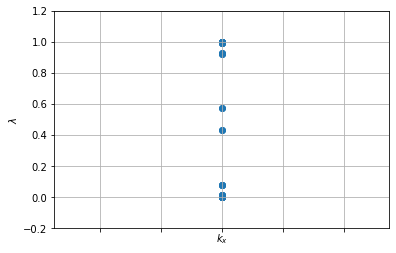

In [68]:
plt.scatter(NN,EE)
plt.grid()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=[0.0],      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel("$k_x$")
plt.ylim(-0.2,1.2)
plt.ylabel("$\lambda$")
plt.savefig("./PlotDataTorus/mz"+str(mz)+"Mz"+str(Mz)+"delPair"+str(delPair)+"nyCutoff"+str(nyCutoff)+".pdf")

In [311]:
np.savetxt("mz"+str(mz)+"Mz"+str(Mz)+"nyCutoff"+str(nyCutoff)+".dat",np.c_[NN,EE])

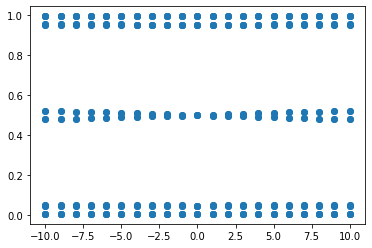

In [271]:
plt.scatter(NN,EE)

In [69]:
HBDG = np.matrix(DH(2,Ly/2))

In [70]:
HBDGT = HBDG.getH()

In [54]:
np.allclose(HBDG,HBDGT)

True

In [56]:
HBDG

matrix([[ 9.48793196e+07-9.36779543e-10j,
         -3.85753810e-06-7.45058060e-09j,
          6.49282443e-10+9.94478391e-11j,
          8.02280366e-10-2.05835803e-11j,
          1.02780759e-05+1.37016177e-05j,
          9.47387889e-06-1.42715871e-05j,
          2.07218659e-10+3.85298318e-10j,
         -6.73560882e-11-1.41088615e-10j,
          1.66571699e-05-1.49011612e-08j,
         -1.27743359e-10+2.84940267e-11j,
          1.58952709e-10-2.48849191e-11j,
         -2.20419294e+07-4.86124892e-10j,
          7.89645676e-04-3.97257794e-03j,
          7.99385502e-04-1.19177338e-02j,
         -1.33304865e-18+7.96931500e-19j,
         -6.66524325e-19+3.98465750e-19j,
          1.57055825e-02+7.47027448e-03j,
         -1.26825514e-02+1.26420354e-02j,
         -3.85232265e-03-1.83233621e-03j,
         -2.55035030e-19-4.26603920e-19j,
         -2.71986701e-18-1.73694426e-18j,
          1.54843888e-19-9.25697438e-20j,
         -3.44094874e-03+5.12997936e-02j,
          3.39902374e-03-1.7099931

In [40]:
ny1 = 2
ny2 = 3
ThetaCut = Ly/2
DiracOverlap(2,ny1,2,ny2,1,-1,ThetaCut)

0j

In [86]:
for i in range(10,-10-1,-1):
    print(i)

10
9
8
7
6
5
4
3
2
1
0
-1
-2
-3
-4
-5
-6
-7
-8
-9
-10
